# Lending Tree Loan Status: Upsampling
## Classification - LinearSVC HPO GPU

## Set Up Environment, Read Data, Split Train/Test Sets

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/RAPIDS/

/content/drive/MyDrive/RAPIDS


In [ ]:
# Clone RAPIDS-Colab install files and see if GPU is compatible
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/env-check.py

In [ ]:
# Update the Colab environment and restart the kernel
!bash rapidsai-csp-utils/colab/update_gcc.sh
import os
os._exit(00)

In [ ]:
# Install CondaColab and restart the kernel 
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:27
🔁 Restarting kernel...


In [ ]:
# See if environment is ready to install RAPIDS
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [ ]:
# Install RAPIDS using the 'stable' release
!python rapidsai-csp-utils/colab/install_rapids.py stable
import os
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
os.environ['CONDA_PREFIX'] = '/usr/local'

In [ ]:
# Install/import dependencies
!pip install optuna
!pip install dask_optuna
import os
import warnings
import random
import numpy as np
import cupy as cp
from cupy import asnumpy
import dask
from dask.distributed import Client, wait
from dask.diagnostics import ProgressBar
from dask.utils import parse_bytes
from dask_cuda import LocalCUDACluster
import dask_cudf
import dask_optuna
import urllib.request
from contextlib import contextmanager
import time
from datetime import datetime, timedelta
from timeit import default_timer as timer
import cudf
import cuml
from cuml.svm import LinearSVC
import optuna
from optuna import Trial
optuna.logging.set_verbosity(optuna.logging.WARNING) 
import joblib
import pickle
import pandas as pd
import sklearn
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import classification_report, confusion_matrix
import plotly.offline as py
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
print('\n')
!/usr/local/cuda/bin/nvcc --version
!nvidia-smi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 5.1 MB/s 
     |████████████████████████████████| 209 kB 48.0 MB/s 
     |████████████████████████████████| 1.6 MB 56.3 MB/s 
     |████████████████████████████████| 81 kB 8.1 MB/s 
     |████████████████████████████████| 150 kB 39.8 MB/s 
     |████████████████████████████████| 78 kB 5.6 MB/s 
     |████████████████████████████████| 112 kB 49.2 MB/s 
     |████████████████████████████████| 49 kB 3.3 MB/s 
     |████████████████████████████████| 146 kB 52.2 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=0956f79ba4babe07eb9f602a5cfe245025433b02734b91c21dcb392e091a5245
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/sim

In [ ]:
# Define function to time code blocks
@contextmanager
def timed(name):
    t0 = time.time()
    yield
    t1 = time.time()
    print('..%-24s:  %8.4f' % (name, t1 - t0))

In [ ]:
# Set up local CUDA cluster for Dask
cluster = LocalCUDACluster(threads_per_worker=1, ip='', dashboard_address='8082') 
c = Client(cluster)

# Query the client for all connected workers
workers = c.has_what().keys()
n_workers = len(workers)
c

<Client: 'tcp://172.28.0.2:44503' processes=1 threads=1, memory=25.46 GiB>

In [ ]:
# Set seed 
seed_value = 42
os.environ['LinearSVC_GPU'] = str(seed_value)
random.seed(seed_value)
cp.random.seed(seed_value)
np.random.seed(seed_value)

In [ ]:
%cd /content/drive/MyDrive/LoanStatus/Data/

/content/drive/MyDrive/LoanStatus/Data


In [ ]:
# Read data
trainDF = cudf.read_csv('trainDF_US.csv', low_memory=False)
print('Train set: Number of rows and columns:', trainDF.shape)

testDF = cudf.read_csv('testDF_US.csv', low_memory=False)
print('Test set: Number of rows and columns:', testDF.shape)

Train set: Number of rows and columns: (3022132, 51)
Test set: Number of rows and columns: (432473, 51)


In [ ]:
# Set up features and target
X_train, y_train = trainDF.drop('loan_status', 
                                axis=1), trainDF['loan_status'].astype('int32')
X_train = X_train.astype('float32')

X_test, y_test= testDF.drop('loan_status', 
                            axis=1), testDF['loan_status'].astype('int32')
X_test = X_test.astype('float32')

## Weighted F1 

### 100 Trials

In [ ]:
%cd /content/drive/MyDrive/LoanStatus/Python/Models/ML/LinearSVC/Optuna/Model_PKL/

# Define a name for the trials
study_name = 'dask_linearSVC_optuna_US_100_weightedF1_tpe'

/content/drive/MyDrive/LoanStatus/Python/Models/ML/LinearSVC/Optuna/Model_PKL


In [ ]:
# Define function to train/evaluate the model
def train_and_eval(X_param, y_param, penalty='l2', 
                   loss='squared_hinge', 
                   penalized_intercept='False', 
                   max_iter=10000, 
                   linesearch_max_iter=100, 
                   lbfgs_memory=5, C=1, 
                   grad_tol=0.0001, change_tol=1e-5, 
                   verbose=False): 
    """
    Partition data into train/test sets, train and evaluate the model
    for the given parameters.
        
    Params
    ______
        
    X_param:  DataFrame. 
              The data to use for training and testing. 
    y_param:  Series. 
              The label for training

    Returns
    score: Weighted F1 of the fitted model
    """
    
    # Set up train/test sets
    X_train, y_train = trainDF.drop('loan_status', 
                                    axis=1), trainDF['loan_status'].astype('int32')
    X_train = X_train.astype('float32')

    X_test, y_test= testDF.drop('loan_status', 
                                axis=1), testDF['loan_status'].astype('int32')
    X_test = X_test.astype('float32')

    # Define model
    model = LinearSVC(penalty=penalty, 
                      loss=loss, 
                      penalized_intercept=penalized_intercept, 
                      max_iter=max_iter, 
                      linesearch_max_iter=linesearch_max_iter, 
                      lbfgs_memory=lbfgs_memory, 
                      C=C, 
                      grad_tol=grad_tol, 
                      change_tol=change_tol,  
                      verbose=False)  
    
    # Start timer for each trial
    start = timer()

    # Fit model
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    score = f1_score(y_test.to_numpy(), y_pred.to_numpy(), average='weighted')
    run_time = timer() - start
    print('- Trial time:', run_time) 
    print('- Trial weighted F1:', score)
    print('######################################################')

    return score

In [ ]:
print('Score with default parameters : ', train_and_eval(X_train, y_train))

[W] [15:35:01.693102] L-BFGS line search failed (code 4); stopping at the last valid step
- Trial time: 0.4067193920000136
- Trial weighted F1: 0.8147946302801139
######################################################
Score with default parameters :  0.8147946302801139


In [ ]:
# Define objective function with the parameters to be tested
def objective(trial, X_param, y_param):

    joblib.dump(study, 'LinearSVC_Optuna_US_100_GPU_weightedF1.pkl')

    # Search parameters
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    loss = trial.suggest_categorical('loss', ['squared_hinge', 'hinge']) 
    penalized_intercept = trial.suggest_categorical('penalized_intercept', 
                                                    ['True', 'False'])
    max_iter = trial.suggest_int('max_iter', -1, 10e6)
    linesearch_max_iter = trial.suggest_int('linesearch_max_iter', 100, 10000)  
    lbfgs_memory = trial.suggest_int('lbfgs_memory', 5, 20) 
    C = trial.suggest_float('C', 0.1, 10, step=0.1)
    grad_tol = trial.suggest_float('grad_tol', 1e-3, 1e-1)
    change_tol = trial.suggest_float('change_tol', 1e-5, 1e-3) 

    score = train_and_eval(X_param,
                           y_param,
                           penalty=penalty, 
                           loss=loss, 
                           penalized_intercept=penalized_intercept, 
                           max_iter=max_iter, 
                           linesearch_max_iter=linesearch_max_iter, 
                           lbfgs_memory=lbfgs_memory, 
                           C=C, 
                           grad_tol=grad_tol, 
                           change_tol=change_tol, 
                           verbose=False)

    return score

In [ ]:
with timed('dask_optuna'):
    # Begin HPO trials 
    # Start timer for experiment
    start_time = datetime.now()
    print('%-20s %s' % ('Start Time', start_time))
    if os.path.isfile('LinearSVC_Optuna_US_100_GPU_weightedF1.pkl'): 
      study = joblib.load('LinearSVC_Optuna_US_100_GPU_weightedF1.pkl')
    else: 
      study = optuna.create_study(sampler=optuna.samplers.TPESampler(), 
                                  study_name=study_name,
                                  direction='maximize')
      
    # Optimize in parallel on Dask cluster
    with parallel_backend('dask'):
        study.optimize(lambda trial: objective(trial, X_train, y_train), 
                       n_trials=100,
                       n_jobs=n_workers)

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Highest F1 Score', study.best_value)

Start Time           2022-06-28 15:35:02.028988
- Trial time: 1.010697130999688
- Trial weighted F1: 0.9722554311196091
######################################################
[W] [15:35:03.512480] L-BFGS line search failed (code 4); stopping at the last valid step
- Trial time: 0.3935817709998446
- Trial weighted F1: 0.8147946302801139
######################################################
[W] [15:35:04.074429] L-BFGS line search failed (code 4); stopping at the last valid step
- Trial time: 0.38537491599981877
- Trial weighted F1: 0.8147946302801139
######################################################
[W] [15:35:04.639034] L-BFGS line search failed (code 4); stopping at the last valid step
- Trial time: 0.3775045379998119
- Trial weighted F1: 0.8147946302801139
######################################################
[W] [15:35:06.111900] QWL-QN stopped, because the line search failed to advance (step delta = 0.000000)
- Trial time: 1.314135816000089
- Trial weighted F1: 0.97386257201

In [ ]:
%cd /content/drive/MyDrive/LoanStatus/Python/Models/ML/LinearSVC/Optuna/trialOptions/

/content/drive/MyDrive/LoanStatus/Python/Models/ML/LinearSVC/Optuna/trialOptions


In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number': 'iteration'}, inplace=True)
trials_df.rename(columns={'value': 'f1_weighted'}, inplace=True)
trials_df.rename(columns={'params_C': 'C'}, inplace=True)
trials_df.rename(columns={'params_change_tol': 'change_tol'}, inplace=True)
trials_df.rename(columns={'params_grad_tol': 'grad_tol'}, inplace=True)
trials_df.rename(columns={'params_lbfgs_memory': 'lbfgs_memory'}, inplace=True)
trials_df.rename(columns={'params_linesearch_max_iter': 'linesearch_max_iter'}, 
                 inplace=True)
trials_df.rename(columns={'params_loss': 'loss'}, inplace=True)
trials_df.rename(columns={'params_max_iter': 'max_iter'}, inplace=True)
trials_df.rename(columns={'params_penalized_intercept': 'penalized_intercept'}, 
                 inplace=True)
trials_df.rename(columns={'params_penalty': 'penatly'}, inplace=True)

# Write processed data to csv
trials_df = trials_df.sort_values('f1_weighted', ascending=False)
trials_df.to_csv('LinearSVC_Optuna_US_100_GPU_weightedF1.csv', index=False)
print(trials_df) 

    iteration  f1_weighted             datetime_start  \
27         27     0.977404 2022-06-28 15:35:39.456973   
63         63     0.977391 2022-06-28 15:36:30.618930   
25         25     0.975667 2022-06-28 15:35:37.299182   
22         22     0.975491 2022-06-28 15:35:32.425700   
92         92     0.975444 2022-06-28 15:37:17.089781   
..        ...          ...                        ...   
26         26     0.814795 2022-06-28 15:35:38.883446   
3           3     0.814795 2022-06-28 15:35:04.330834   
2           2     0.814795 2022-06-28 15:35:03.798425   
59         59     0.814795 2022-06-28 15:36:25.560220   
99         99     0.814795 2022-06-28 15:37:29.177828   

            datetime_complete               duration    C  change_tol  \
27 2022-06-28 15:35:41.332008 0 days 00:00:01.875035  7.9    0.000254   
63 2022-06-28 15:36:32.436435 0 days 00:00:01.817505  3.2    0.000679   
25 2022-06-28 15:35:38.883297 0 days 00:00:01.584115  7.8    0.000236   
22 2022-06-28 15:35:33.

In [ ]:
%cd /content/drive/MyDrive/LoanStatus/Python/Models/ML/LinearSVC/Optuna/Model_Explanations/

/content/drive/MyDrive/LoanStatus/Python/Models/ML/LinearSVC/Optuna/Model_Explanations


In [ ]:
# Plot_optimization_history: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_LinearSVC_Optuna_US_100_GPU_weightedF1.html')
fig.show()

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_LinearSVC_Optuna_US_100_GPU_weightedF1.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_LinearSVC_Optuna_US_100_GPU_weightedF1.html')
fig.show()

In [ ]:
# plot_contour: plots parameter interactions on an interactive chart. 
fig = optuna.visualization.plot_contour(study, params=['C',
                                                       'change_tol',
                                                       'grad_tol',
                                                       'lbfgs_memory',
                                                       'linesearch_max_iter',
                                                       'max_iter'])
py.plot(fig, filename='contour_LinearSVC_Optuna_US_100_GPU_weightedF1.html')
fig.show()

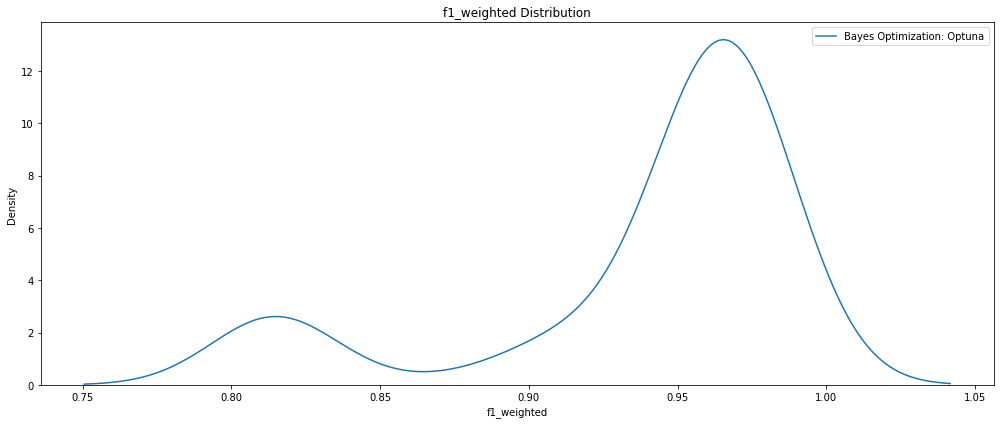

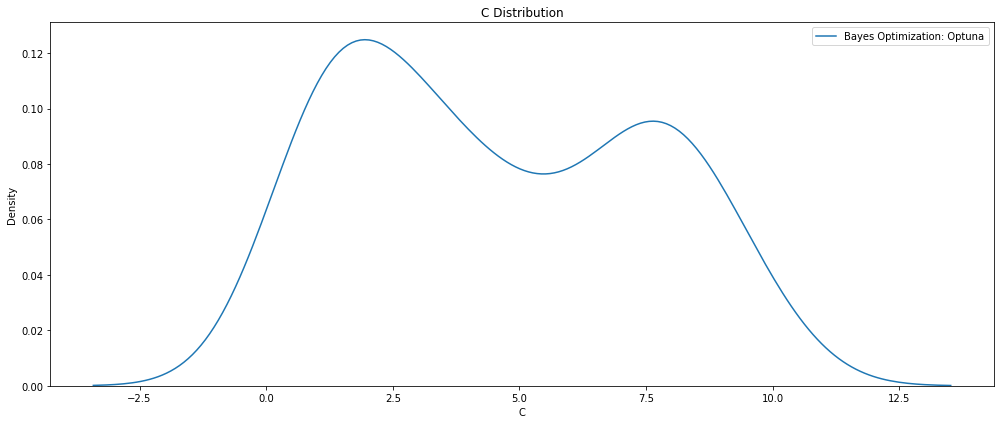

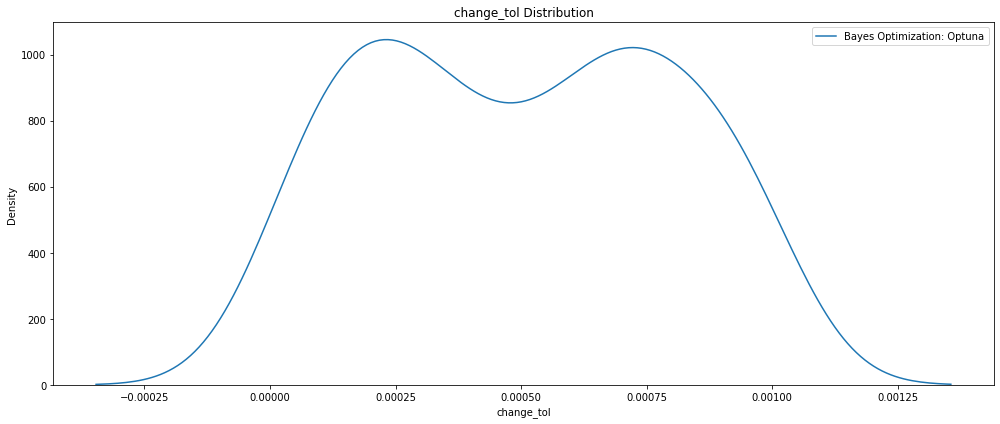

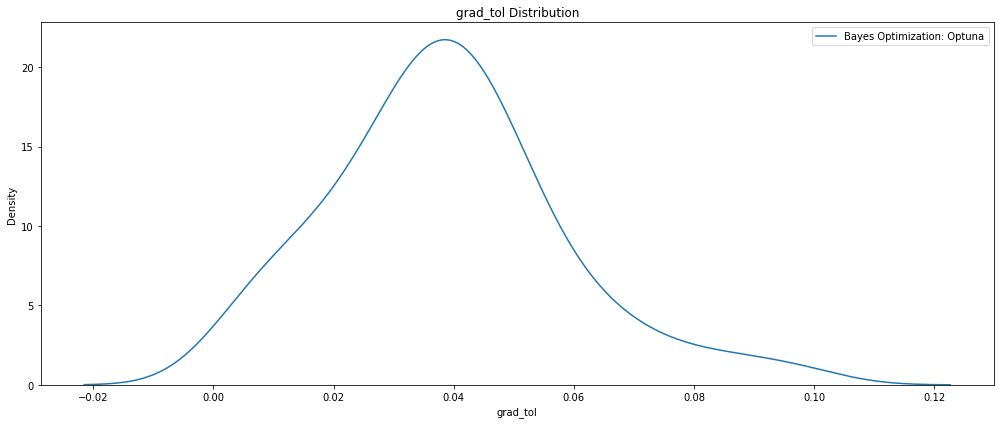

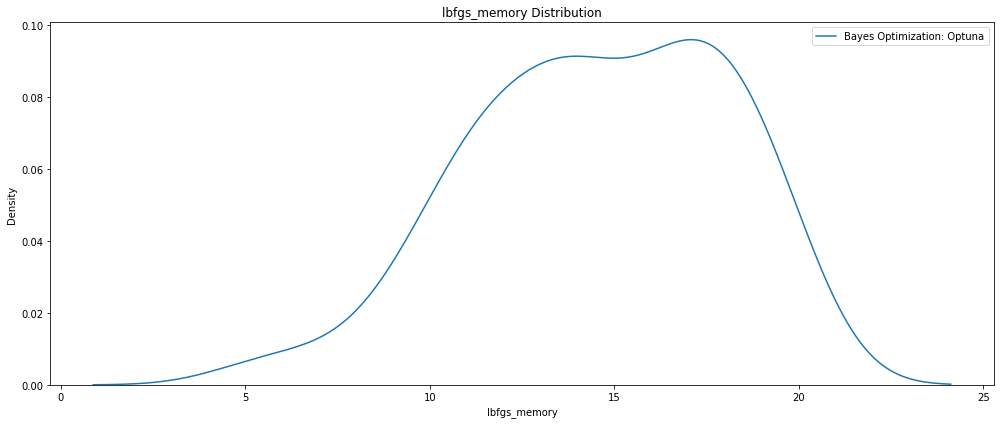

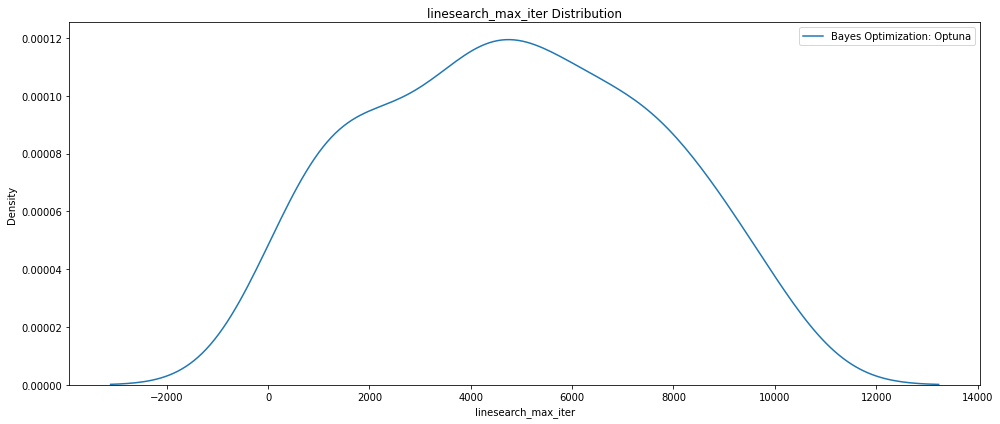

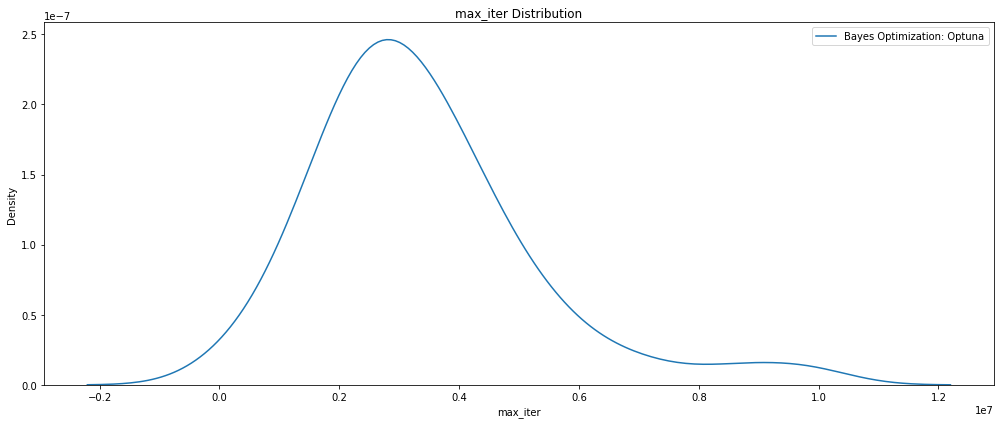

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'datetime_start', 'datetime_complete',
                   'duration', 'loss', 'penatly', 'penalized_intercept', 'state']: 
        plt.figure(figsize=(14,6))
        # Plot the bayes search distribution
        if hpo != 'loss':
          sns.kdeplot(trials_df[hpo], label='Bayes Optimization: Optuna')
          plt.legend(loc=0)
          plt.title('{} Distribution'.format(hpo))
          plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
          plt.tight_layout()
          plt.show()

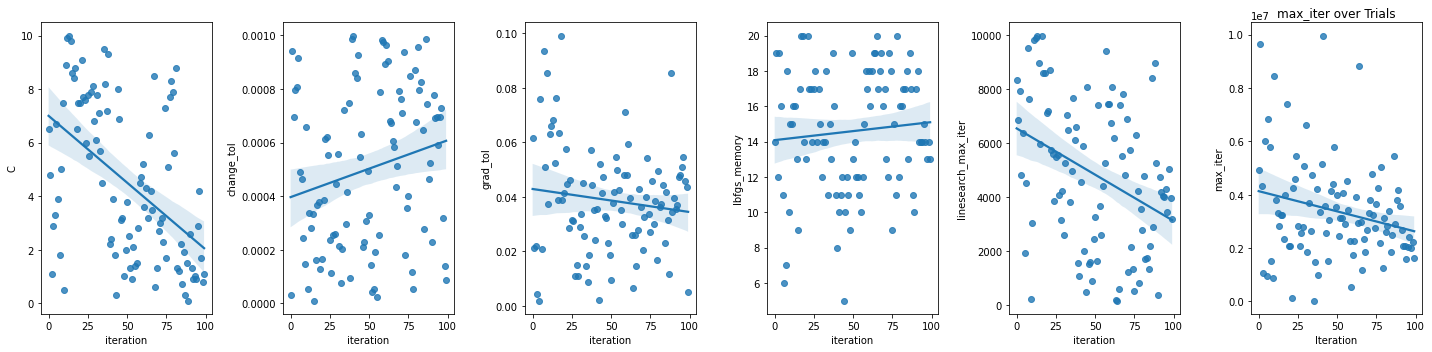

In [ ]:
# Plot quantitative hyperparameters
fig, axs = plt.subplots(1, 6, figsize=(20,5))
i = 0
axs = axs.flatten()
for i, hpo in enumerate(['C', 'change_tol', 'grad_tol', 
                         'lbfgs_memory', 'linesearch_max_iter', 'max_iter']): 
  # Scatterplot
  sns.regplot('iteration', hpo, data=trials_df, ax=axs[i]) 
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo),  
             title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [ ]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_LinearSVC_Optuna_US_100_GPU_weightedF1.html')
fig.show()

In [ ]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_LinearSVC_Optuna_US_100_GPU_weightedF1.html')
fig.show()

In [ ]:
# Arrange best parameters to fit model for model metrics
params = study.best_params   
params

{'C': 7.9,
 'change_tol': 0.0002542098250104354,
 'grad_tol': 0.010976199943976632,
 'lbfgs_memory': 14,
 'linesearch_max_iter': 4076,
 'loss': 'squared_hinge',
 'max_iter': 2564428,
 'penalized_intercept': 'True',
 'penalty': 'l1'}

In [ ]:
%cd /content/drive/MyDrive/LoanStatus/Python/Models/ML/LinearSVC/Optuna/Model_PKL/

/content/drive/MyDrive/LoanStatus/Python/Models/ML/LinearSVC/Optuna/Model_PKL


In [ ]:
# Re-create the best model and train on the training data
best_model = LinearSVC(**params)

# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'LinearSVC_Optuna_US_trials100_GPU_weightedF1.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('LinearSVC_Optuna_US_trials100_GPU_weightedF1.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for LinearSVC HPO Upsampling 100trials GPU')
# Predict based on training 
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
print('\n')
print('Classification Report:')
clf_rpt = classification_report(y_test.to_numpy(), y_test_pred.to_numpy())
print(clf_rpt)
print('\n')
print('Confusion matrix:')
print(confusion_matrix(y_test.to_numpy(), y_test_pred.to_numpy()))
print('\n')
print('Accuracy score : %.3f' % accuracy_score(y_test.to_numpy(), 
                                               y_test_pred.to_numpy()))
print('Precision score : %.3f' % precision_score(y_test.to_numpy(), 
                                                 y_test_pred.to_numpy()))
print('Recall score : %.3f' % recall_score(y_test.to_numpy(), 
                                           y_test_pred.to_numpy()))
print('F1 score : %.3f' % f1_score(y_test.to_numpy(), y_test_pred.to_numpy()))


Model Metrics for LinearSVC HPO Upsampling 100trials GPU


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98    377848
           1       0.80      0.88      0.84     54625

    accuracy                           0.96    432473
   macro avg       0.89      0.92      0.91    432473
weighted avg       0.96      0.96      0.96    432473



Confusion matrix:
[[365934  11914]
 [  6582  48043]]


Accuracy score : 0.957
Precision score : 0.801
Recall score : 0.880
F1 score : 0.839


In [ ]:
# Evaluate on the testing data 
print('The best model from Upsampling 100 GPU trials optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(y_test.to_numpy(), 
                                                                                                                               y_test_pred.to_numpy())))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from Upsampling 100 GPU trials optimization scores 0.92399 AUC ROC on the test set.
This was achieved using these conditions:
iteration                                      27
f1_weighted                              0.977404
datetime_start         2022-06-28 15:35:39.456973
datetime_complete      2022-06-28 15:35:41.332008
duration                   0 days 00:00:01.875035
C                                             7.9
change_tol                               0.000254
grad_tol                                 0.010976
lbfgs_memory                                   14
linesearch_max_iter                          4076
loss                                squared_hinge
max_iter                                  2564428
penalized_intercept                          True
penatly                                        l1
state                                    COMPLETE
Name: 27, dtype: object


## Weighted ROC

### 100 Trials

In [ ]:
%cd /content/drive/MyDrive/LoanStatus/Python/Models/ML/LinearSVC/Optuna/Model_PKL/

# Define a name for the trials
study_name = 'dask_linearSVC_optuna_US_100_weightedROC_tpe'

/content/drive/MyDrive/LoanStatus/Python/Models/ML/LinearSVC/Optuna/Model_PKL


In [ ]:
# Define function to train/evaluate the model
def train_and_eval(X_param, y_param, penalty='l1', 
                   loss='squared_hinge', 
                   penalized_intercept='False', 
                   max_iter=10000, 
                   linesearch_max_iter=100, 
                   lbfgs_memory=5, C=1, 
                   grad_tol=0.0001, change_tol=1e-5, 
                   verbose=False): 
    """
    Partition data into train/test sets, train and evaluate the model
    for the given parameters.
        
    Params
    ______
        
    X_param:  DataFrame. 
              The data to use for training and testing. 
    y_param:  Series. 
              The label for training

    Returns
    score: Weighted ROC of the fitted model
    """
    
    # Set up train/test sets
    X_train, y_train = trainDF.drop('loan_status', 
                                    axis=1), trainDF['loan_status'].astype('int32')
    X_train = X_train.astype('float32')

    X_test, y_test= testDF.drop('loan_status', 
                                axis=1), testDF['loan_status'].astype('int32')
    X_test = X_test.astype('float32')

    # Define model
    model = LinearSVC(penalty=penalty, 
                      loss=loss, 
                      penalized_intercept=penalized_intercept, 
                      max_iter=max_iter, 
                      linesearch_max_iter=linesearch_max_iter, 
                      lbfgs_memory=lbfgs_memory, 
                      C=C, 
                      grad_tol=grad_tol, 
                      change_tol=change_tol,  
                      verbose=False)  
    
    # Start timer for each trial
    start = timer()

    # Fit model
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    score = roc_auc_score(y_test.to_numpy(), y_pred.to_numpy(), 
                          average='weighted')
    run_time = timer() - start
    print('- Trial time:', run_time) 
    print('- Trial weighted ROC:', score)
    print('######################################################')

    return score

In [ ]:
print('Score with default parameters : ', train_and_eval(X_train, y_train))

[W] [14:57:39.693207] QWL-QN stopped, because the line search failed to advance (step delta = 0.000000)
- Trial time: 4.217213180000272
- Trial weighted ROC: 0.8962107584869282
######################################################
Score with default parameters :  0.8962107584869282


In [ ]:
# Define objective function with the parameters to be tested
def objective(trial, X_param, y_param):

    joblib.dump(study, 'LinearSVC_Optuna_US_100_GPU_ROCweighted.pkl')

    # Search parameters
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    loss = trial.suggest_categorical('loss', ['squared_hinge', 'hinge']) 
    penalized_intercept = trial.suggest_categorical('penalized_intercept', 
                                                    ['True', 'False'])
    max_iter = trial.suggest_int('max_iter', -1, 10e6)
    linesearch_max_iter = trial.suggest_int('linesearch_max_iter', 100, 10000)  
    lbfgs_memory = trial.suggest_int('lbfgs_memory', 5, 20) 
    C = trial.suggest_float('C', 0.1, 10, step=0.1)
    grad_tol = trial.suggest_float('grad_tol', 1e-3, 1e-1)
    change_tol = trial.suggest_float('change_tol', 1e-5, 1e-3) 

    score = train_and_eval(X_param,
                           y_param,
                           penalty=penalty, 
                           loss=loss, 
                           penalized_intercept=penalized_intercept, 
                           max_iter=max_iter, 
                           linesearch_max_iter=linesearch_max_iter, 
                           lbfgs_memory=lbfgs_memory, 
                           C=C, 
                           grad_tol=grad_tol, 
                           change_tol=change_tol, 
                           verbose=False)

    return score

In [ ]:
with timed('dask_optuna'):
    # Begin HPO trials 
    # Start timer for experiment
    start_time = datetime.now()
    print('%-20s %s' % ('Start Time', start_time))
    if os.path.isfile('LinearSVC_Optuna_US_100_GPU_ROCweighted.pkl'): 
      study = joblib.load('LinearSVC_Optuna_US_100_GPU_ROCweighted.pkl')
    else: 
      study = optuna.create_study(sampler=optuna.samplers.TPESampler(), 
                                  study_name=study_name,
                                  direction='maximize')
      
    # Optimize in parallel on Dask cluster
    with parallel_backend('dask'):
        study.optimize(lambda trial: objective(trial, X_train, y_train), 
                       n_trials=100,
                       n_jobs=n_workers)

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Highest ROCweighted score', study.best_value)

Start Time           2022-06-28 14:58:18.205950
[W] [14:58:18.545326] L-BFGS line search failed (code 4); stopping at the last valid step
- Trial time: 0.29279905199973655
- Trial weighted ROC: 0.5
######################################################
[W] [14:58:19.001105] L-BFGS line search failed (code 4); stopping at the last valid step
- Trial time: 0.2634990849996939
- Trial weighted ROC: 0.5
######################################################
[W] [14:58:19.418506] L-BFGS line search failed (code 4); stopping at the last valid step
- Trial time: 0.2729198809997797
- Trial weighted ROC: 0.5
######################################################
- Trial time: 2.148124091000227
- Trial weighted ROC: 0.9298843381235427
######################################################
[W] [14:58:22.171553] L-BFGS line search failed (code 4); stopping at the last valid step
- Trial time: 0.271169867000026
- Trial weighted ROC: 0.5
######################################################
[W] [14:

In [ ]:
%cd /content/drive/MyDrive/LoanStatus/Python/Models/ML/LinearSVC/Optuna/trialOptions/

/content/drive/MyDrive/LoanStatus/Python/Models/ML/LinearSVC/Optuna/trialOptions


In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number': 'iteration'}, inplace=True)
trials_df.rename(columns={'value':' roc_weighted'}, inplace=True)
trials_df.rename(columns={'params_C': 'C'}, inplace=True)
trials_df.rename(columns={'params_change_tol': 'change_tol'}, inplace=True)
trials_df.rename(columns={'params_grad_tol': 'grad_tol'}, inplace=True)
trials_df.rename(columns={'params_lbfgs_memory': 'lbfgs_memory'}, inplace=True)
trials_df.rename(columns={'params_linesearch_max_iter': 'linesearch_max_iter'}, 
                 inplace=True)
trials_df.rename(columns={'params_loss': 'loss'}, inplace=True)
trials_df.rename(columns={'params_max_iter': 'max_iter'}, inplace=True)
trials_df.rename(columns={'params_penalized_intercept': 'penalized_intercept'}, 
                 inplace=True)
trials_df.rename(columns={'params_penalty': 'penatly'}, inplace=True)

# Write processed data to csv
trials_df = trials_df.sort_values('roc_weighted', ascending=False)
trials_df.to_csv('LinearSVC_Optuna_US_100_GPU_ROCweighted.csv', index=False)
print(trials_df) 

    iteration  roc_weighted             datetime_start  \
81         81      0.932016 2022-06-28 15:00:05.776827   
91         91      0.932016 2022-06-28 15:00:19.499691   
73         73      0.932016 2022-06-28 14:59:55.287970   
22         22      0.931134 2022-06-28 14:58:47.636707   
25         25      0.931132 2022-06-28 14:58:51.459528   
..        ...           ...                        ...   
35         35      0.500000 2022-06-28 14:59:05.058572   
34         34      0.500000 2022-06-28 14:59:04.503061   
78         78      0.500000 2022-06-28 15:00:02.293027   
0           0      0.500000 2022-06-28 14:58:18.211223   
99         99           NaN 2022-06-28 15:00:31.526235   

            datetime_complete               duration    C  change_tol  \
81 2022-06-28 15:00:07.113156 0 days 00:00:01.336329  1.9    0.000360   
91 2022-06-28 15:00:21.007778 0 days 00:00:01.508087  1.9    0.000335   
73 2022-06-28 14:59:56.694460 0 days 00:00:01.406490  1.9    0.000335   
22 2022-06-

In [ ]:
%cd /content/drive/MyDrive/LoanStatus/Python/Models/ML/LinearSVC/Optuna/Model_Explanations/

/content/drive/MyDrive/LoanStatus/Python/Models/ML/LinearSVC/Optuna/Model_Explanations


In [ ]:
# Plot_optimization_history: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_LinearSVC_Optuna_US_100_GPU_ROCweighted.html')
fig.show()

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_LinearSVC_Optuna_US_100_GPU_ROCweighted.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_LinearSVC_Optuna_LinearSVC_100_GPU_ROCweighted.html')
fig.show()

In [ ]:
# plot_contour: plots parameter interactions on an interactive chart. 
fig = optuna.visualization.plot_contour(study, params=['C',
                                                       'change_tol',
                                                       'grad_tol',
                                                       'lbfgs_memory',
                                                       'linesearch_max_iter',
                                                       'max_iter'])
py.plot(fig, filename='contour_LinearSVC_Optuna_US_100_GPU.html')
fig.show()

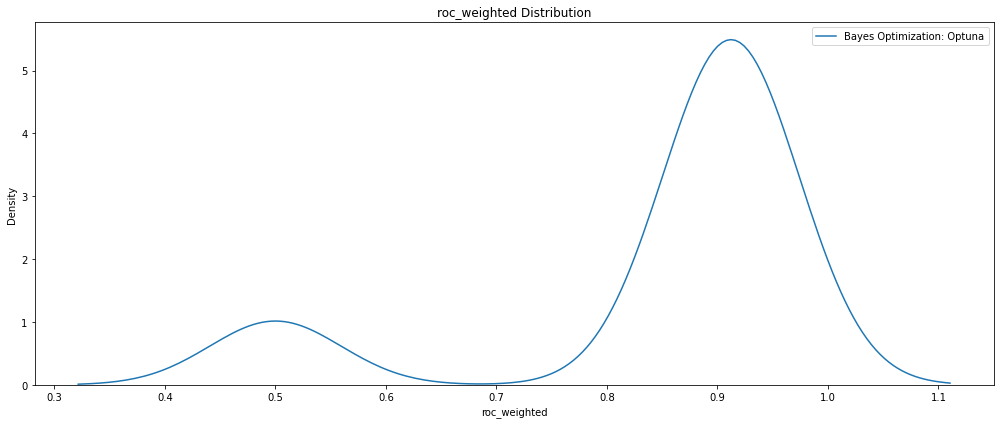

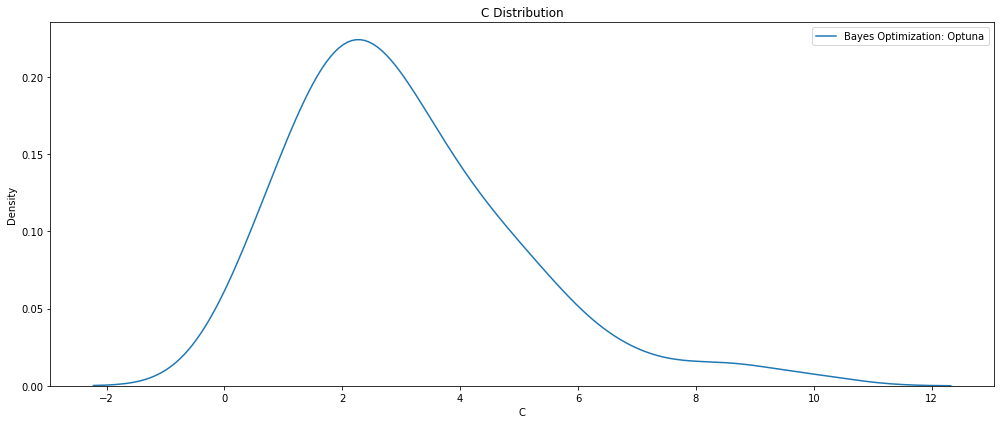

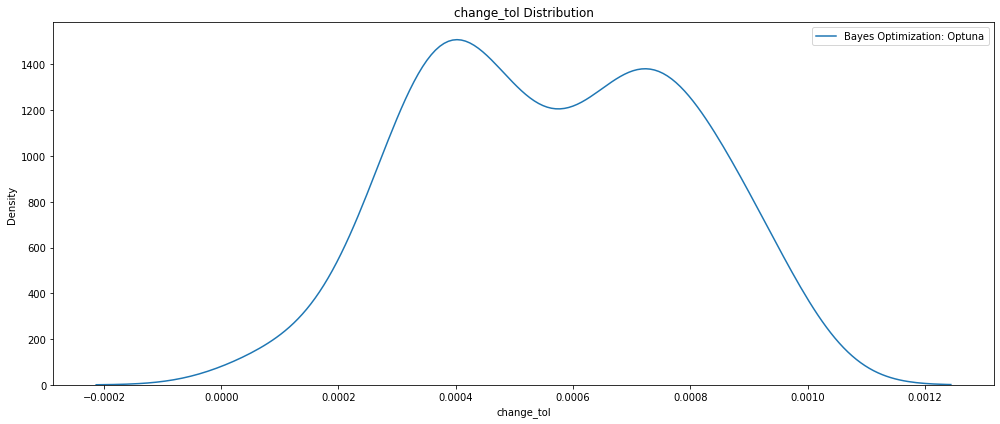

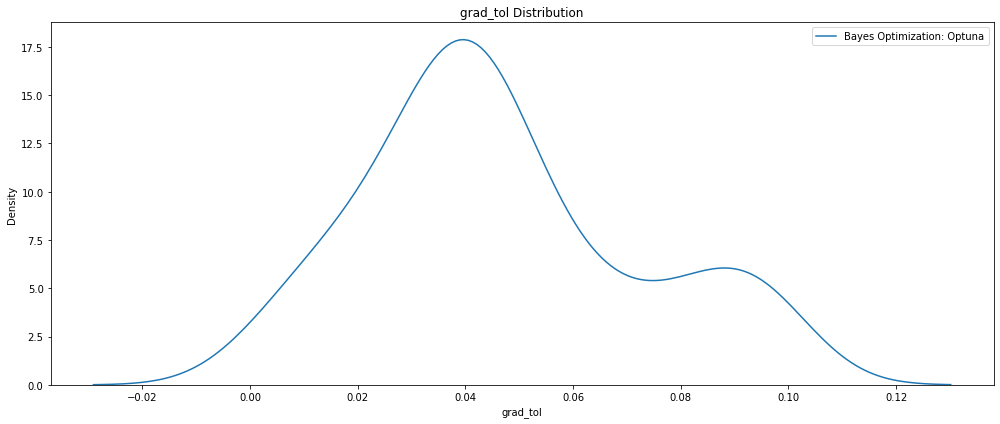

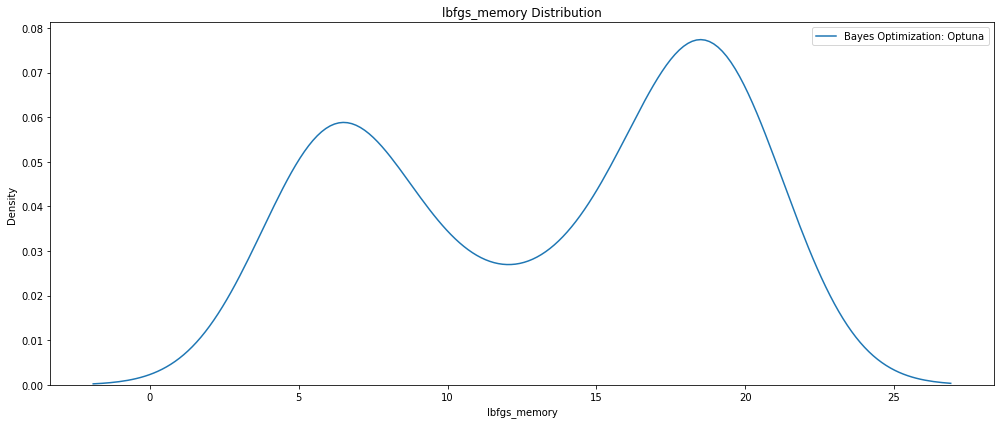

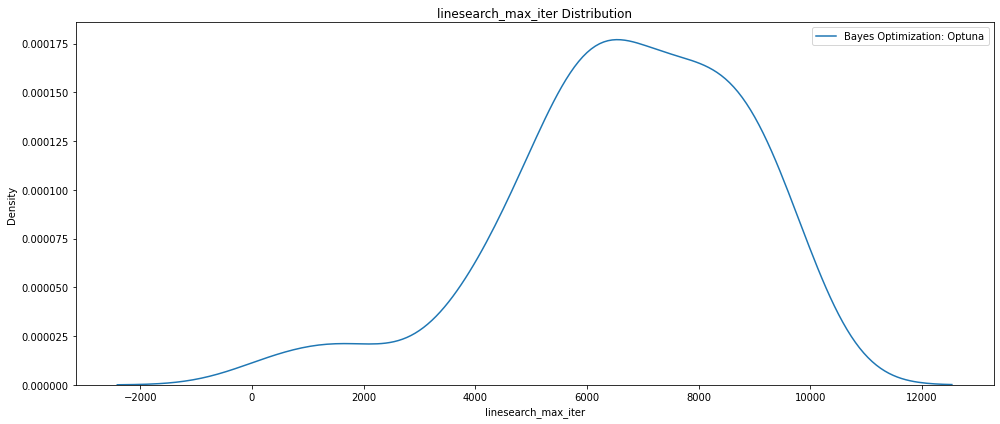

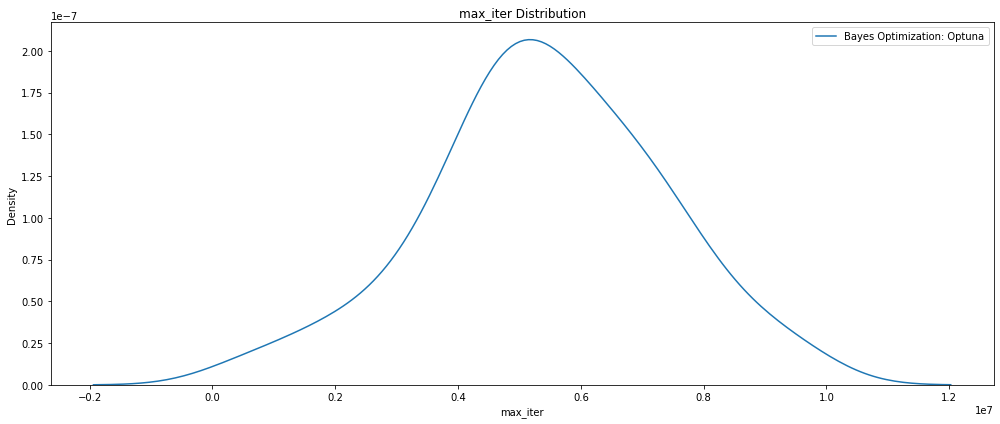

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'datetime_start', 'datetime_complete',
                   'duration', 'loss', 'penatly', 'penalized_intercept', 'state']: 
        plt.figure(figsize=(14,6))
        # Plot  the bayes search distribution
        if hpo != 'loss':
          sns.kdeplot(trials_df[hpo], label='Bayes Optimization: Optuna')
          plt.legend(loc=0)
          plt.title('{} Distribution'.format(hpo))
          plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
          plt.tight_layout()
          plt.show()

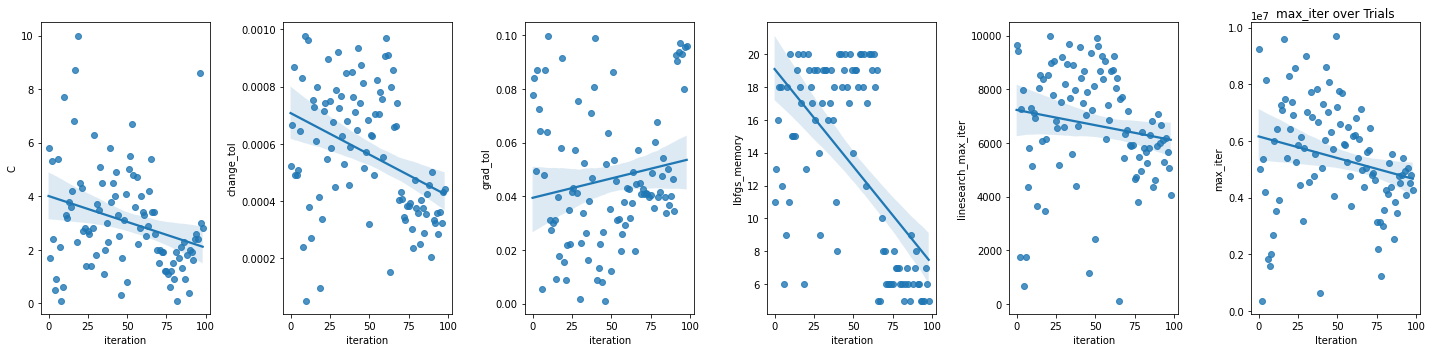

In [ ]:
# Plot quantitative hyperparameters
fig, axs = plt.subplots(1, 6, figsize=(20,5))
i = 0
axs = axs.flatten()
for i, hpo in enumerate(['C', 'change_tol', 'grad_tol', 
                         'lbfgs_memory', 'linesearch_max_iter', 'max_iter']): 
  # Scatterplot
  sns.regplot('iteration', hpo, data=trials_df, ax=axs[i]) 
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo),  
             title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [ ]:
%cd /content/drive/MyDrive/LoanStatus/Python/Models/ML/LinearSVC/Optuna/Model_Explanations/

/content/drive/MyDrive/LoanStatus/Python/Models/ML/LinearSVC/Optuna/Model_Explanations


In [ ]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_LinearSVC_Optuna_US_100_GPU_ROCweighted.html')
fig.show()

In [ ]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_LinearSVC_Optuna_US_100_GPU_ROCweighted.html')
fig.show()

In [ ]:
# Arrange best parameters to fit model for model metrics
params = study.best_params   
params

{'C': 1.9000000000000001,
 'change_tol': 0.00033518176108840014,
 'grad_tol': 0.04075414000146681,
 'lbfgs_memory': 6,
 'linesearch_max_iter': 5885,
 'loss': 'squared_hinge',
 'max_iter': 4858535,
 'penalized_intercept': 'False',
 'penalty': 'l1'}

In [ ]:
%cd /content/drive/MyDrive/LoanStatus/Python/Models/ML/LinearSVC/Optuna/Model_PKL/

/content/drive/MyDrive/LoanStatus/Python/Models/ML/LinearSVC/Optuna/Model_PKL


In [ ]:
# Re-create the best model and train on the training data
best_model = LinearSVC(**params)

# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'LinearSVC_Optuna_US_trials100_GPU_ROCweighted.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('LinearSVC_Optuna_US_trials100_GPU_ROCweighted.pkl')
# print(model)
# =============================================================================

[W] [15:00:48.966419] QWL-QN stopped, because the line search failed to advance (step delta = 0.000000)


In [ ]:
print('\nModel Metrics for LinearSVC HPO Upsampling 100 trials GPU ROCweighted')
# Predict based on training 
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
print('\n')
print('Classification Report:')
clf_rpt = classification_report(y_test.to_numpy(), y_test_pred.to_numpy())
print(clf_rpt)
print('\n')
print('Confusion matrix:')
print(confusion_matrix(y_test.to_numpy(), y_test_pred.to_numpy()))
print('\n')
print('Accuracy score : %.3f' % accuracy_score(y_test.to_numpy(), 
                                               y_test_pred.to_numpy()))
print('Precision score : %.3f' % precision_score(y_test.to_numpy(), 
                                                 y_test_pred.to_numpy()))
print('Recall score : %.3f' % recall_score(y_test.to_numpy(), 
                                           y_test_pred.to_numpy()))
print('F1 score : %.3f' % f1_score(y_test.to_numpy(), y_test_pred.to_numpy()))


Model Metrics for LinearSVC HPO Upsampling 100 trials GPU ROCweighted


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99    377848
           1       0.92      0.87      0.90     54625

    accuracy                           0.97    432473
   macro avg       0.95      0.93      0.94    432473
weighted avg       0.97      0.97      0.97    432473



Confusion matrix:
[[373883   3965]
 [  6854  47771]]


Accuracy score : 0.975
Precision score : 0.923
Recall score : 0.875
F1 score : 0.898


In [ ]:
# Evaluate on the testing data 
print('The best model from Upsampling 100 ROCweighted GPU trials optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(y_test.to_numpy(), 
                                                                                                                                           y_test_pred.to_numpy())))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from Upsampling 100 ROCweighted GPU trials optimization scores 0.93202 AUC ROC on the test set.
This was achieved using these conditions:
iteration                                      81
roc_weighted                             0.932016
datetime_start         2022-06-28 15:00:05.776827
datetime_complete      2022-06-28 15:00:07.113156
duration                   0 days 00:00:01.336329
C                                             1.9
change_tol                                0.00036
grad_tol                                 0.041482
lbfgs_memory                                  6.0
linesearch_max_iter                        5799.0
loss                                squared_hinge
max_iter                                4287426.0
penalized_intercept                         False
penatly                                        l1
state                                    COMPLETE
Name: 81, dtype: object


## Recall

### 100 Trials

In [ ]:
%cd /content/drive/MyDrive/LoanStatus/Python/Models/ML/LinearSVC/Optuna/Model_PKL/

# Define a name for the trials
study_name = 'dask_linearSVC_optuna_US_100_recall_tpe'

/content/drive/MyDrive/LoanStatus/Python/Models/ML/LinearSVC/Optuna/Model_PKL


In [ ]:
# Define function to train/evaluate the model
def train_and_eval(X_param, y_param, penalty='l1', 
                   loss='squared_hinge', 
                   penalized_intercept='False', 
                   max_iter=10000, 
                   linesearch_max_iter=100, 
                   lbfgs_memory=5, C=1, 
                   grad_tol=0.0001, change_tol=1e-5, 
                   verbose=False): 
    """
    Partition data into train/test sets, train and evaluate the model
    for the given parameters.
        
    Params
    ______
        
    X_param:  DataFrame. 
              The data to use for training and testing. 
    y_param:  Series. 
              The label for training

    Returns
    score: Recall of the fitted model
    """
    
    # Set up train/test sets
    X_train, y_train = trainDF.drop('loan_status', 
                                    axis=1), trainDF['loan_status'].astype('int32')
    X_train = X_train.astype('float32')

    X_test, y_test= testDF.drop('loan_status', 
                                axis=1), testDF['loan_status'].astype('int32')
    X_test = X_test.astype('float32')

    # Define model
    model = LinearSVC(penalty=penalty, 
                      loss=loss, 
                      penalized_intercept=penalized_intercept, 
                      max_iter=max_iter, 
                      linesearch_max_iter=linesearch_max_iter, 
                      lbfgs_memory=lbfgs_memory, 
                      C=C, 
                      grad_tol=grad_tol, 
                      change_tol=change_tol,  
                      verbose=False)  
    
    # Start timer for each trial
    start = timer()

    # Fit model
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    score = recall_score(y_test.to_numpy(), y_pred.to_numpy())
    run_time = timer() - start
    print('- Trial time:', run_time) 
    print('- Trial Recall:', score)
    print('######################################################')

    return score

In [ ]:
print('Score with default parameters : ', train_and_eval(X_train, y_train))

[W] [15:17:05.229482] QWL-QN stopped, because the line search failed to advance (step delta = 0.000000)
- Trial time: 1.8388673339995876
- Trial Recall: 0.870370709382151
######################################################
Score with default parameters :  0.870370709382151


In [ ]:
# Define objective function with the parameters to be tested
def objective(trial, X_param, y_param):

    joblib.dump(study, 'LinearSVC_Optuna_US_100_GPU_Recall.pkl')

    # Search parameters
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    loss = trial.suggest_categorical('loss', ['squared_hinge', 'hinge']) 
    penalized_intercept = trial.suggest_categorical('penalized_intercept', 
                                                    ['True', 'False'])
    max_iter = trial.suggest_int('max_iter', -1, 10e6)
    linesearch_max_iter = trial.suggest_int('linesearch_max_iter', 100, 10000)  
    lbfgs_memory = trial.suggest_int('lbfgs_memory', 5, 20) 
    C = trial.suggest_float('C', 0.1, 10, step=0.1)
    grad_tol = trial.suggest_float('grad_tol', 1e-3, 1e-1)
    change_tol = trial.suggest_float('change_tol', 1e-5, 1e-3) 

    score = train_and_eval(X_param,
                           y_param,
                           penalty=penalty, 
                           loss=loss, 
                           penalized_intercept=penalized_intercept, 
                           max_iter=max_iter, 
                           linesearch_max_iter=linesearch_max_iter, 
                           lbfgs_memory=lbfgs_memory, 
                           C=C, 
                           grad_tol=grad_tol, 
                           change_tol=change_tol, 
                           verbose=False)

    return score

In [ ]:
with timed('dask_optuna'):
    # Begin HPO trials 
    # Start timer for experiment
    start_time = datetime.now()
    print('%-20s %s' % ('Start Time', start_time))
    if os.path.isfile('LinearSVC_Optuna_US_100_GPU_Recall.pkl'): 
      study = joblib.load('LinearSVC_Optuna_US_100_GPU_Recall.pkl')
    else: 
      study = optuna.create_study(sampler=optuna.samplers.TPESampler(), 
                                  study_name=study_name,
                                  direction='maximize')
      
    # Optimize in parallel on Dask cluster
    with parallel_backend('dask'):
        study.optimize(lambda trial: objective(trial, X_train, y_train), 
                       n_trials=100,
                       n_jobs=n_workers)

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Highest Recall score', study.best_value)

Start Time           2022-06-28 15:17:28.537400
[W] [15:17:28.830852] L-BFGS line search failed (code 4); stopping at the last valid step
- Trial time: 0.38506062499982363
- Trial Recall: 0.0
######################################################
[W] [15:17:29.398632] L-BFGS line search failed (code 4); stopping at the last valid step
- Trial time: 0.3913883380000698
- Trial Recall: 0.0
######################################################
[W] [15:17:29.955616] L-BFGS line search failed (code 4); stopping at the last valid step
- Trial time: 0.37175592399944435
- Trial Recall: 0.0
######################################################
[W] [15:17:30.507713] L-BFGS line search failed (code 4); stopping at the last valid step
- Trial time: 0.37471868699958577
- Trial Recall: 0.0
######################################################
- Trial time: 1.5867669150002257
- Trial Recall: 0.8745629290617849
######################################################
- Trial time: 1.1988892829995166
-

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/Python/Models/ML/LinearSVC/Optuna/trialOptions/

/content/drive/MyDrive/LoanStatus/ML/LinearSVC/Optuna/trialOptions


In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number': 'iteration'}, inplace=True)
trials_df.rename(columns={'value': 'recall'}, inplace=True)
trials_df.rename(columns={'params_C': 'C'}, inplace=True)
trials_df.rename(columns={'params_change_tol': 'change_tol'}, inplace=True)
trials_df.rename(columns={'params_grad_tol': 'grad_tol'}, inplace=True)
trials_df.rename(columns={'params_lbfgs_memory': 'lbfgs_memory'}, inplace=True)
trials_df.rename(columns={'params_linesearch_max_iter': 'linesearch_max_iter'}, 
                 inplace=True)
trials_df.rename(columns={'params_loss': 'loss'}, inplace=True)
trials_df.rename(columns={'params_max_iter': 'max_iter'}, inplace=True)
trials_df.rename(columns={'params_penalized_intercept': 'penalized_intercept'}, 
                 inplace=True)
trials_df.rename(columns={'params_penalty': 'penatly'}, inplace=True)

# Write processed data to csv
trials_df = trials_df.sort_values('recall', ascending=False)
trials_df.to_csv('LinearSVC_Optuna_US_100_GPU_Recall.csv', index=False)
print(trials_df) 

    iteration    recall             datetime_start          datetime_complete  \
26         26  0.924778 2022-06-28 15:18:05.104735 2022-06-28 15:18:07.347467   
57         57  0.924485 2022-06-28 15:18:54.035742 2022-06-28 15:18:55.474776   
99         99  0.924449 2022-06-28 15:19:59.779168 2022-06-28 15:20:00.960531   
84         84  0.924449 2022-06-28 15:19:39.946063 2022-06-28 15:19:40.998920   
97         97  0.924449 2022-06-28 15:19:57.146224 2022-06-28 15:19:58.208550   
..        ...       ...                        ...                        ...   
60         60  0.000000 2022-06-28 15:18:58.821733 2022-06-28 15:18:59.442735   
36         36  0.000000 2022-06-28 15:18:18.316594 2022-06-28 15:18:18.931055   
38         38  0.000000 2022-06-28 15:18:23.543477 2022-06-28 15:18:24.148161   
1           1  0.000000 2022-06-28 15:17:29.079552 2022-06-28 15:17:29.680715   
0           0  0.000000 2022-06-28 15:17:28.540672 2022-06-28 15:17:29.079416   

                 duration  

In [ ]:
%cd /content/drive/MyDrive/LoanStatus/Python/Models/ML/LinearSVC/Optuna/Model_Explanations/

/content/drive/MyDrive/LoanStatus/Python/Models/ML/LinearSVC/Optuna/Model_Explanations


In [ ]:
# Plot_optimization_history: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_LinearSVC_Optuna_US_100_GPU_Recall.html')
fig.show()

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_LinearSVC_Optuna_US_100_GPU_Recall.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_LinearSVC_Optuna_LinearSVC_100_GPU_Recall.html')
fig.show()

In [ ]:
# plot_contour: plots parameter interactions on an interactive chart. 
fig = optuna.visualization.plot_contour(study, params=['C',
                                                       'change_tol',
                                                       'grad_tol',
                                                       'lbfgs_memory',
                                                       'linesearch_max_iter',
                                                       'max_iter'])
py.plot(fig, filename='contour_LinearSVC_Optuna_US_100_GPU_Recall.html')
fig.show()

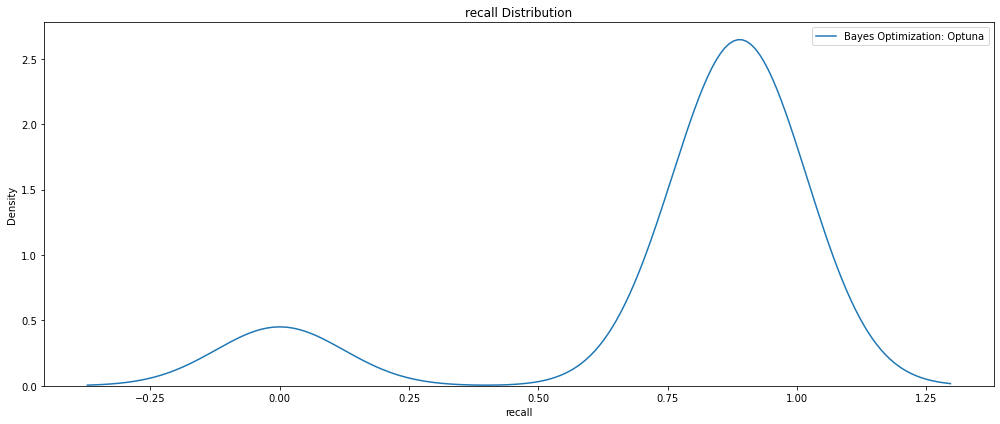

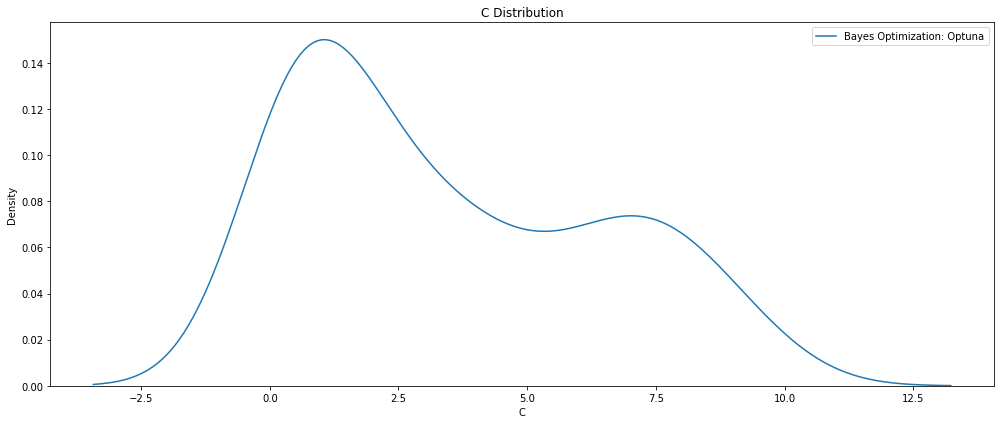

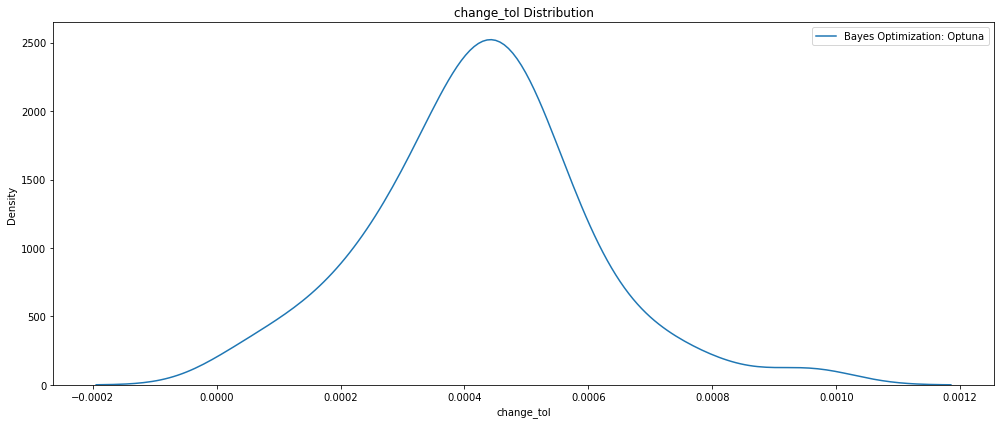

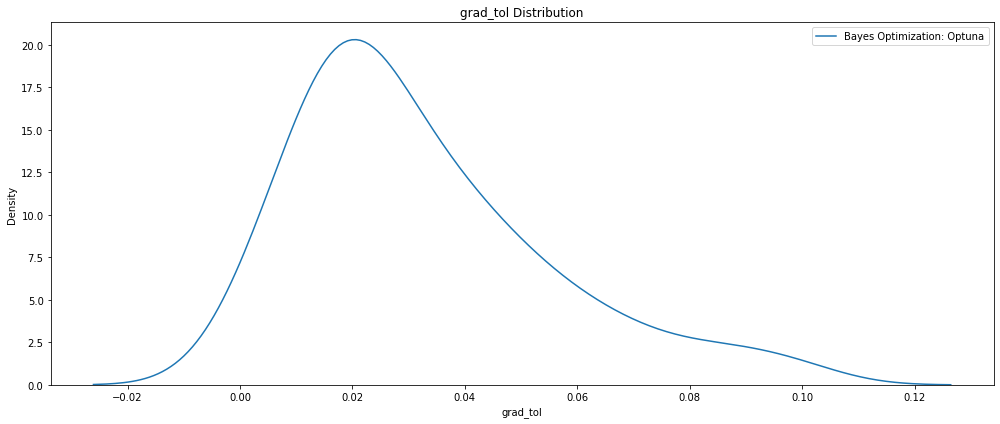

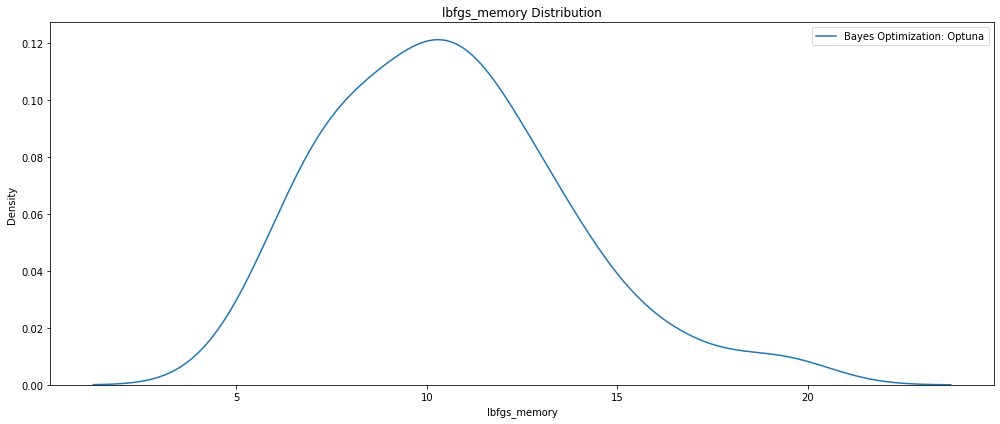

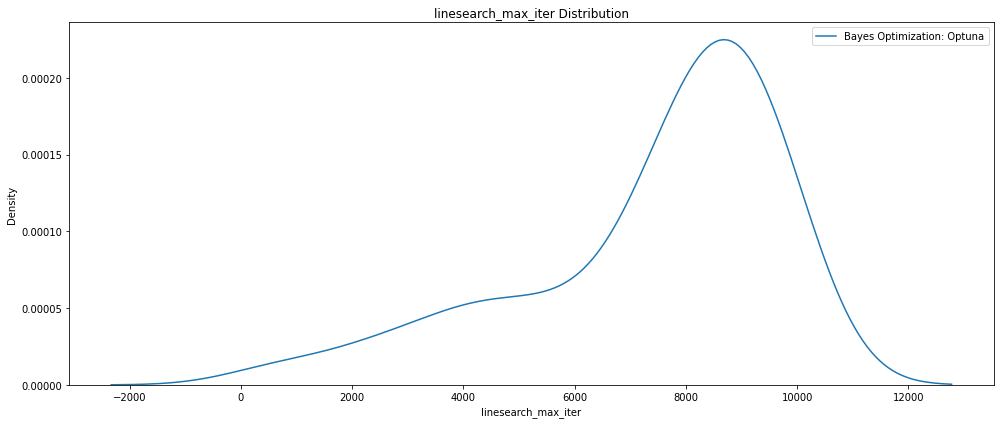

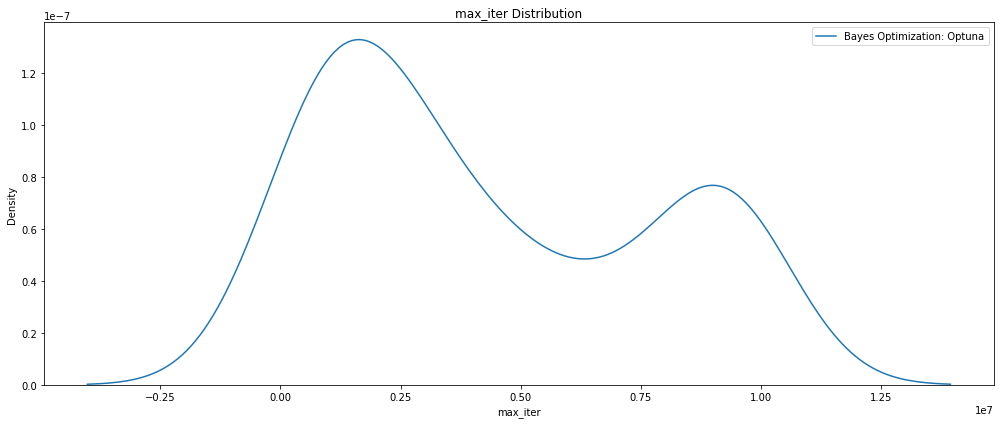

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'datetime_start', 'datetime_complete',
                   'duration', 'loss', 'penatly', 'penalized_intercept', 'state']: 
        plt.figure(figsize=(14,6))
        # Plot the bayes search distribution
        if hpo != 'loss':
          sns.kdeplot(trials_df[hpo], label='Bayes Optimization: Optuna')
          plt.legend(loc=0)
          plt.title('{} Distribution'.format(hpo))
          plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
          plt.tight_layout()
          plt.show()

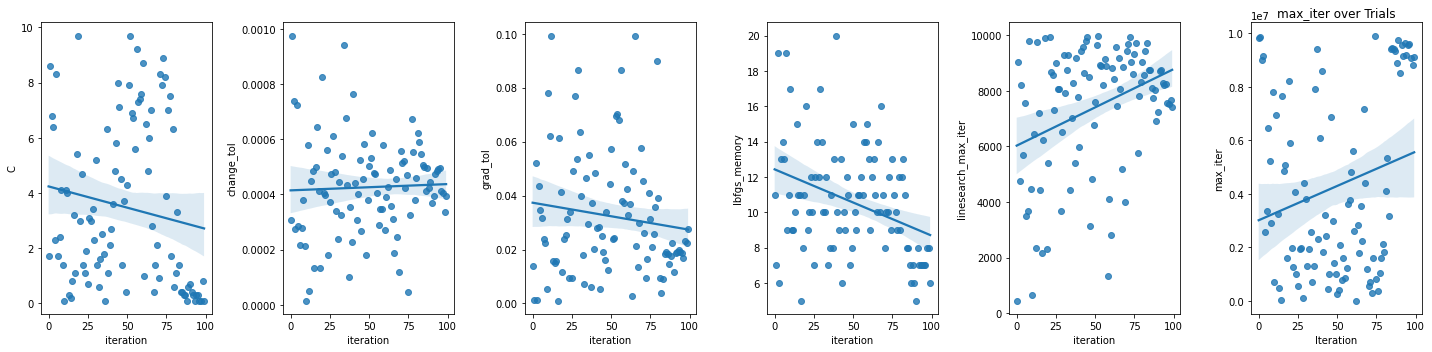

In [ ]:
# Plot quantitative hyperparameters
fig, axs = plt.subplots(1, 6, figsize=(20,5))
i = 0
axs = axs.flatten()
for i, hpo in enumerate(['C', 'change_tol', 'grad_tol', 
                         'lbfgs_memory', 'linesearch_max_iter', 'max_iter']): 
  # Scatterplot
  sns.regplot('iteration', hpo, data=trials_df, ax=axs[i]) 
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo),  
             title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [ ]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_LinearSVC_Optuna_US_100_GPU_Recall.html')
fig.show()

In [ ]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_LinearSVC_Optuna_US_100_GPU_Recall.html')
fig.show()

In [ ]:
# Arrange best parameters to fit model for model metrics
params = study.best_params   
params

{'C': 3.1,
 'change_tol': 0.00047337966924705383,
 'grad_tol': 0.049133957136332035,
 'lbfgs_memory': 12,
 'linesearch_max_iter': 8080,
 'loss': 'squared_hinge',
 'max_iter': 1956718,
 'penalized_intercept': 'True',
 'penalty': 'l1'}

In [ ]:
%cd /content/drive/MyDrive/LoanStatus/Python/Models/ML/LinearSVC/Optuna/Model_PKL/

/content/drive/MyDrive/LoanStatus/Python/Models/ML/LinearSVC/Optuna/Model_PKL


In [ ]:
# Re-create the best model and train on the training data
best_model = LinearSVC(**params)

# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'LinearSVC_Optuna_US_trials100_GPU_Recall.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('LinearSVC_Optuna_US_trials100_GPU_Recall.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for LinearSVC HPO Upsampling 100 trials GPU Recall')
# Predict based on training 
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
print('\n')
print('Classification Report:')
clf_rpt = classification_report(y_test.to_numpy(), y_test_pred.to_numpy())
print(clf_rpt)
print('\n')
print('Confusion matrix:')
print(confusion_matrix(y_test.to_numpy(), y_test_pred.to_numpy()))
print('\n')
print('Accuracy score : %.3f' % accuracy_score(y_test.to_numpy(), 
                                               y_test_pred.to_numpy()))
print('Precision score : %.3f' % precision_score(y_test.to_numpy(), 
                                                 y_test_pred.to_numpy()))
print('Recall score : %.3f' % recall_score(y_test.to_numpy(), 
                                           y_test_pred.to_numpy()))
print('F1 score : %.3f' % f1_score(y_test.to_numpy(), y_test_pred.to_numpy()))


Model Metrics for LinearSVC HPO Upsampling 100 trials GPU Recall


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99    377848
           1       0.93      0.87      0.90     54625

    accuracy                           0.97    432473
   macro avg       0.96      0.93      0.94    432473
weighted avg       0.97      0.97      0.97    432473



Confusion matrix:
[[374258   3590]
 [  7324  47301]]


Accuracy score : 0.975
Precision score : 0.929
Recall score : 0.866
F1 score : 0.897


In [ ]:
# Evaluate on the testing data 
print('The best model from Upsampling 100 Recall GPU trials optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(y_test.to_numpy(), 
                                                                                                                                      y_test_pred.to_numpy())))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from Upsampling 100 Recall GPU trials optimization scores 0.92821 AUC ROC on the test set.
This was achieved using these conditions:
iteration                                      26
recall                                   0.924778
datetime_start         2022-06-28 15:18:05.104735
datetime_complete      2022-06-28 15:18:07.347467
duration                   0 days 00:00:02.242732
C                                             3.1
change_tol                               0.000473
grad_tol                                 0.049134
lbfgs_memory                                   12
linesearch_max_iter                          8080
loss                                squared_hinge
max_iter                                  1956718
penalized_intercept                          True
penatly                                        l1
state                                    COMPLETE
Name: 26, dtype: object


## Precision

### 100 Trials

In [ ]:
%cd /content/drive/MyDrive/LoanStatus/Python/Models/ML/LinearSVC/Optuna/Model_PKL/

# Define a name for the trials
study_name = 'dask_linearSVC_optuna_US_100_precision_tpe'

/content/drive/MyDrive/LoanStatus/Python/Models/ML/LinearSVC/Optuna/Model_PKL


In [ ]:
# Define function to train/evaluate the model
def train_and_eval(X_param, y_param, penalty='l1', 
                   loss='squared_hinge', 
                   penalized_intercept='False', 
                   max_iter=10000, 
                   linesearch_max_iter=100, 
                   lbfgs_memory=5, C=1, 
                   grad_tol=0.0001, change_tol=1e-5, 
                   verbose=False): 
    """
    Partition data into train/test sets, train and evaluate the model
    for the given parameters.
        
    Params
    ______
        
    X_param:  DataFrame. 
              The data to use for training and testing. 
    y_param:  Series. 
              The label for training

    Returns
    score: Precision of the fitted model
    """
    
    # Set up train/test sets
    X_train, y_train = trainDF.drop('loan_status', 
                                    axis=1), trainDF['loan_status'].astype('int32')
    X_train = X_train.astype('float32')

    X_test, y_test= testDF.drop('loan_status', 
                                axis=1), testDF['loan_status'].astype('int32')
    X_test = X_test.astype('float32')

    # Define model
    model = LinearSVC(penalty=penalty, 
                      loss=loss, 
                      penalized_intercept=penalized_intercept, 
                      max_iter=max_iter, 
                      linesearch_max_iter=linesearch_max_iter, 
                      lbfgs_memory=lbfgs_memory, 
                      C=C, 
                      grad_tol=grad_tol, 
                      change_tol=change_tol,  
                      verbose=False)  
    
    # Start timer for each trial
    start = timer()

    # Fit model
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    score = precision_score(y_test.to_numpy(), y_pred.to_numpy())
    run_time = timer() - start
    print('- Trial time:', run_time) 
    print('- Trial Precision:', score)
    print('######################################################')

    return score

In [ ]:
print('Score with default parameters : ', train_and_eval(X_train, y_train))

- Trial time: 4.552626142999543
- Trial Precision: 0.9290369156325606
######################################################
Score with default parameters :  0.9290369156325606


In [ ]:
# Define objective function with the parameters to be tested
def objective(trial, X_param, y_param):

    joblib.dump(study, 'LinearSVC_Optuna_US_100_GPU_Precision.pkl')

    # Search parameters
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    loss = trial.suggest_categorical('loss', ['squared_hinge', 'hinge']) 
    penalized_intercept = trial.suggest_categorical('penalized_intercept', 
                                                    ['True', 'False'])
    max_iter = trial.suggest_int('max_iter', -1, 10e6)
    linesearch_max_iter = trial.suggest_int('linesearch_max_iter', 100, 10000)  
    lbfgs_memory = trial.suggest_int('lbfgs_memory', 5, 20) 
    C = trial.suggest_float('C', 0.1, 10, step=0.1)
    grad_tol = trial.suggest_float('grad_tol', 1e-3, 1e-1)
    change_tol = trial.suggest_float('change_tol', 1e-5, 1e-3) 

    score = train_and_eval(X_param,
                           y_param,
                           penalty=penalty, 
                           loss=loss, 
                           penalized_intercept=penalized_intercept, 
                           max_iter=max_iter, 
                           linesearch_max_iter=linesearch_max_iter, 
                           lbfgs_memory=lbfgs_memory, 
                           C=C, 
                           grad_tol=grad_tol, 
                           change_tol=change_tol, 
                           verbose=False)

    return score

In [ ]:
with timed('dask_optuna'):
    # Begin HPO trials 
    # Start timer for experiment
    start_time = datetime.now()
    print('%-20s %s' % ('Start Time', start_time))
    if os.path.isfile('LinearSVC_Optuna_US_100_GPU_Precision.pkl'): 
      study = joblib.load('LinearSVC_Optuna_US_100_GPU_Precision.pkl')
    else: 
      study = optuna.create_study(sampler=optuna.samplers.TPESampler(), 
                                  study_name=study_name,
                                  direction='maximize')
      
    # Optimize in parallel on Dask cluster
    with parallel_backend('dask'):
        study.optimize(lambda trial: objective(trial, X_train, y_train), 
                       n_trials=100,
                       n_jobs=n_workers)

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Highest Precision score', study.best_value)

Start Time           2022-06-28 15:27:19.880484
- Trial time: 1.1988195490002909
- Trial Precision: 0.5995984271730946
######################################################
- Trial time: 1.6992502610000884
- Trial Precision: 0.8527795919935457
######################################################
- Trial time: 0.9342183789995033
- Trial Precision: 0.563259273500679
######################################################
[W] [15:27:24.540649] L-BFGS line search failed (code 4); stopping at the last valid step
- Trial time: 0.38219656799992663
- Trial Precision: 0.0
######################################################
[W] [15:27:25.086473] L-BFGS line search failed (code 4); stopping at the last valid step
- Trial time: 0.38441606300057174
- Trial Precision: 0.0
######################################################
[W] [15:27:25.656429] L-BFGS line search failed (code 4); stopping at the last valid step
- Trial time: 0.3857505799996943
- Trial Precision: 0.0
#########################

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/Python/Models/ML/LinearSVC/Optuna/trialOptions/

/content/drive/MyDrive/LoanStatus/ML/LinearSVC/Optuna/trialOptions


In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number': 'iteration'}, inplace=True)
trials_df.rename(columns={'value': 'precision'}, inplace=True)
trials_df.rename(columns={'params_C': 'C'}, inplace=True)
trials_df.rename(columns={'params_change_tol': 'change_tol'}, inplace=True)
trials_df.rename(columns={'params_grad_tol': 'grad_tol'}, inplace=True)
trials_df.rename(columns={'params_lbfgs_memor y': 'lbfgs_memory'}, inplace=True)
trials_df.rename(columns={'params_linesearch_max_iter': 'linesearch_max_iter'}, 
                 inplace=True)
trials_df.rename(columns={'params_loss': 'loss'}, inplace=True)
trials_df.rename(columns={'params_max_iter': 'max_iter'}, inplace=True)
trials_df.rename(columns={'params_penalized_intercept': 'penalized_intercept'}, 
                 inplace=True)
trials_df.rename(columns={'params_penalty': 'penatly'}, inplace=True)

# Write processed data to csv
trials_df = trials_df.sort_values('precision', ascending=False)
trials_df.to_csv('LinearSVC_Optuna_US_100_GPU_Precision.csv', index=False)
print(trials_df) 

    iteration  precision             datetime_start  \
23         23   0.947567 2022-06-28 15:27:49.780422   
67         67   0.941919 2022-06-28 15:28:56.829980   
60         60   0.941919 2022-06-28 15:28:45.469587   
26         26   0.941919 2022-06-28 15:27:54.786216   
84         84   0.941919 2022-06-28 15:29:22.537938   
..        ...        ...                        ...   
38         38   0.000000 2022-06-28 15:28:13.877491   
40         40   0.000000 2022-06-28 15:28:15.854631   
47         47   0.000000 2022-06-28 15:28:26.293946   
57         57   0.000000 2022-06-28 15:28:42.060493   
99         99   0.000000 2022-06-28 15:29:45.777529   

            datetime_complete               duration    C  change_tol  \
23 2022-06-28 15:27:51.551142 0 days 00:00:01.770720  7.0    0.000786   
67 2022-06-28 15:28:58.623371 0 days 00:00:01.793391  6.2    0.000717   
60 2022-06-28 15:28:47.191616 0 days 00:00:01.722029  7.4    0.000788   
26 2022-06-28 15:27:56.668955 0 days 00:00:01.8

In [ ]:
%cd /content/drive/MyDrive/LoanStatus/Python/Models/ML/LinearSVC/Optuna/Model_Explanations/

/content/drive/MyDrive/LoanStatus/Python/Models/ML/LinearSVC/Optuna/Model_Explanations


In [ ]:
# Plot_optimization_history: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_LinearSVC_Optuna_US_100_GPU_Precision.html')
fig.show()

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_LinearSVC_Optuna_US_100_GPU_Precision.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_LinearSVC_Optuna_LinearSVC_100_GPU_Precision.html')
fig.show()

In [ ]:
# plot_contour: plots parameter interactions on an interactive chart. 
fig = optuna.visualization.plot_contour(study, params=['C',
                                                       'change_tol',
                                                       'grad_tol',
                                                       'lbfgs_memory',
                                                       'linesearch_max_iter',
                                                       'max_iter'])
py.plot(fig, filename='contour_LinearSVC_Optuna_US_100_GPU_Precision.html')
fig.show()

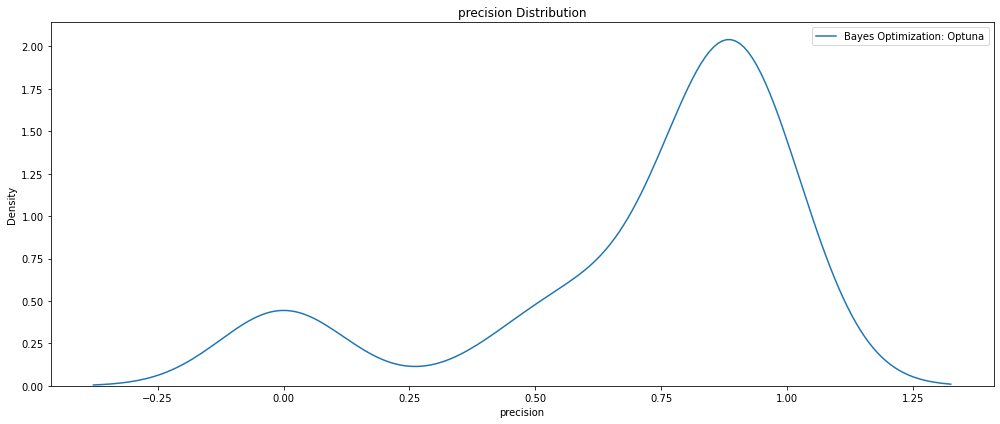

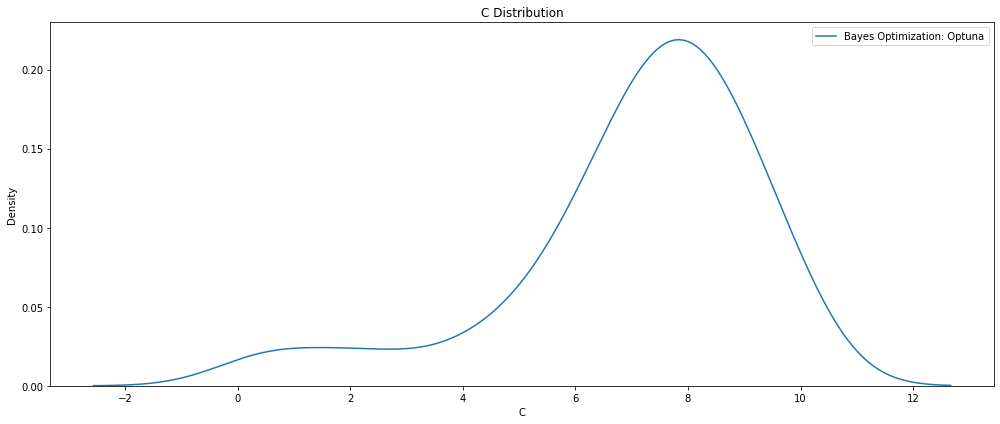

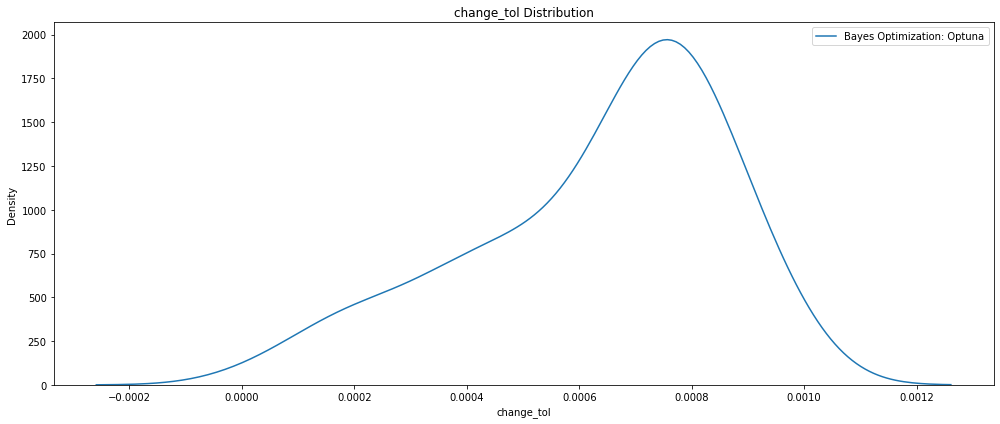

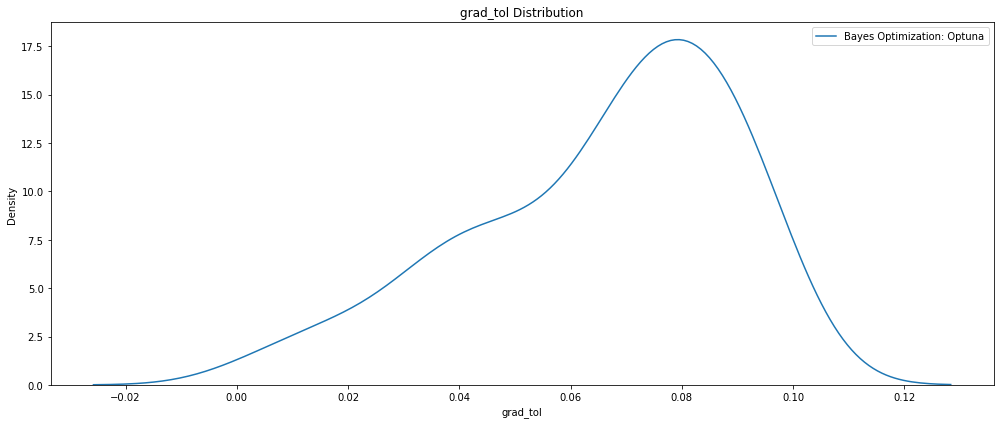

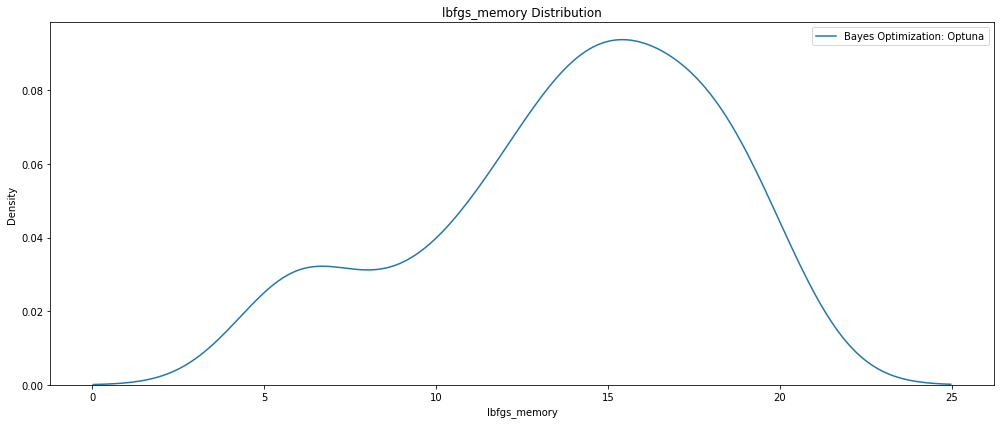

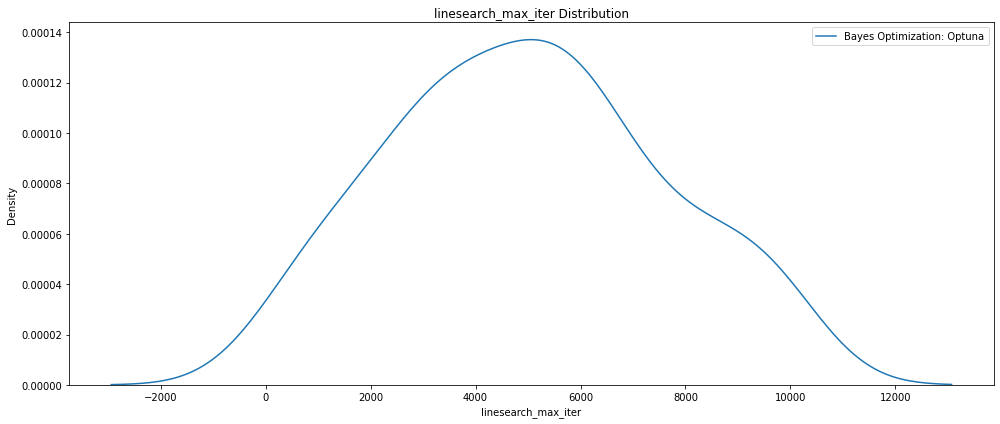

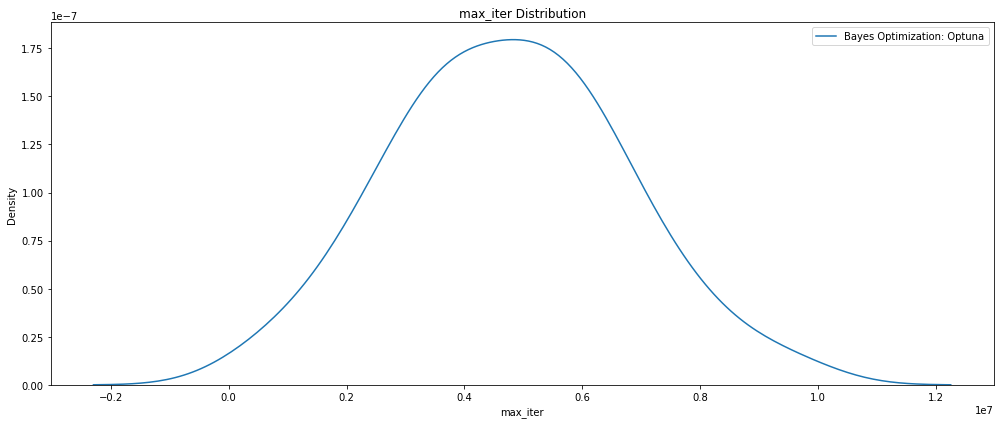

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'datetime_start', 'datetime_complete',
                   'duration', 'loss', 'penatly', 'penalized_intercept', 'state']: 
        plt.figure(figsize=(14,6))
        # Plot the bayes search distribution
        if hpo != 'loss':
          sns.kdeplot(trials_df[hpo], label='Bayes Optimization: Optuna')
          plt.legend(loc=0)
          plt.title('{} Distribution'.format(hpo))
          plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
          plt.tight_layout()
          plt.show()

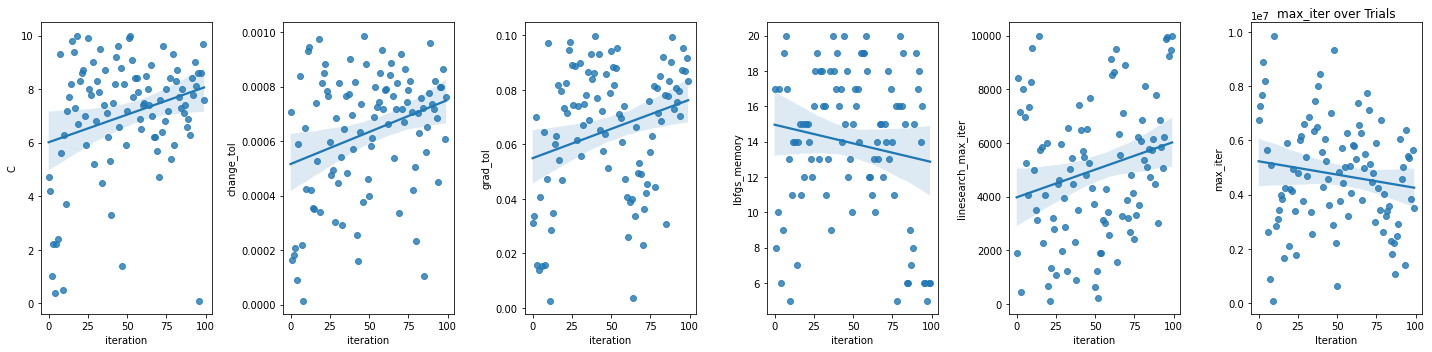

In [ ]:
# Plot quantitative hyperparameters
fig, axs = plt.subplots(1, 6, figsize=(20,5))
i = 0
axs = axs.flatten()
for i, hpo in enumerate(['C', 'change_tol', 'grad_tol', 
                         'lbfgs_memory', 'linesearch_max_iter', 'max_iter']): 
  # Scatterplot
  sns.regplot('iteration', hpo, data=trials_df, ax=axs[i]) 
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo),  
             title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [ ]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_LinearSVC_Optuna_US_100_GPU_Precision.html')
fig.show()

In [ ]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_LinearSVC_Optuna_US_100_GPU_Precision.html')
fig.show()

In [ ]:
# Arrange best parameters to fit model for model metrics
params = study.best_params   
params

{'C': 7.0,
 'change_tol': 0.0007856698175489583,
 'grad_tol': 0.0944843289460105,
 'lbfgs_memory': 13,
 'linesearch_max_iter': 3202,
 'loss': 'squared_hinge',
 'max_iter': 3397210,
 'penalized_intercept': 'False',
 'penalty': 'l1'}

In [ ]:
%cd /content/drive/MyDrive/LoanStatus/Python/Models/ML/LinearSVC/Optuna/Model_PKL/

/content/drive/MyDrive/LoanStatus/Python/Models/ML/LinearSVC/Optuna/Model_PKL


In [ ]:
# Re-create the best model and train on the training data
best_model = LinearSVC(**params)

# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'LinearSVC_Optuna_US_trials100_GPU_Precision.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('LinearSVC_Optuna_US_trials100_GPU_Precision.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for LinearSVC HPO Upsampling 100 trials GPU Precision')
# Predict based on training 
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
print('\n')
print('Classification Report:')
clf_rpt = classification_report(y_test.to_numpy(), y_test_pred.to_numpy())
print(clf_rpt)
print('\n')
print('Confusion matrix:')
print(confusion_matrix(y_test.to_numpy(), y_test_pred.to_numpy()))
print('\n')
print('Accuracy score : %.3f' % accuracy_score(y_test.to_numpy(), 
                                               y_test_pred.to_numpy()))
print('Precision score : %.3f' % precision_score(y_test.to_numpy(), 
                                                 y_test_pred.to_numpy()))
print('Recall score : %.3f' % recall_score(y_test.to_numpy(), 
                                           y_test_pred.to_numpy()))
print('F1 score : %.3f' % f1_score(y_test.to_numpy(), y_test_pred.to_numpy()))


Model Metrics for LinearSVC HPO Upsampling 100 trials GPU Precision


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99    377848
           1       0.95      0.84      0.89     54625

    accuracy                           0.97    432473
   macro avg       0.96      0.92      0.94    432473
weighted avg       0.97      0.97      0.97    432473



Confusion matrix:
[[375310   2538]
 [  8758  45867]]


Accuracy score : 0.974
Precision score : 0.948
Recall score : 0.840
F1 score : 0.890


In [ ]:
# Evaluate on the testing data 
print('The best model from Upsampling 100 Precision GPU trials optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(y_test.to_numpy(), 
                                                                                                                                         y_test_pred.to_numpy())))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from Upsampling 100 Precision GPU trials optimization scores 0.91648 AUC ROC on the test set.
This was achieved using these conditions:
iteration                                      23
precision                                0.947567
datetime_start         2022-06-28 15:27:49.780422
datetime_complete      2022-06-28 15:27:51.551142
duration                   0 days 00:00:01.770720
C                                             7.0
change_tol                               0.000786
grad_tol                                 0.094484
lbfgs_memory                                   13
linesearch_max_iter                          3202
loss                                squared_hinge
max_iter                                  3397210
penalized_intercept                         False
penatly                                        l1
state                                    COMPLETE
Name: 23, dtype: object
